In [2]:
## Задание 1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев
## в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline


In [3]:
def mse(y_true, y_pred):
    return np.sum((y_true - y_pred)**2) / len(y_true)

In [4]:
X, y = load_diabetes(return_X_y=True)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [6]:
class GradientBoostingRegressor:
    def __init__(self, *args, n_iters=100, learning_rate=0.01, **kwargs):
        self.args = args
        self.kwargs = kwargs
        self.n_iters = n_iters
        self.learning_rate = learning_rate
        self.trees = None
        self.train_errors = None
        self.test_errors = None
        
    def fit(self, X_train, y_train, X_test=None, y_test=None):
        X_train = pd.DataFrame(X_train)
        y_train = pd.Series(y_train)
        self.trees = []
        self.train_errors = []
        self.test_errors = []
        for _ in range(self.n_iters):
            tree = DecisionTreeRegressor(*self.args, **self.kwargs)
            if len(self.trees) == 0:
                tree.fit(X_train, y_train)
            else:
                y_pred = self.predict(X_train)
                tree.fit(X_train, self.bias(y_train, y_pred))

            self.trees.append(tree)

            self.train_errors.append(mse(y_train, self.predict(X_train)))
            if (X_test is not None) and (y_test is not None):
                self.test_errors.append(mse(y_test, self.predict(X_test)))

    @staticmethod
    def bias(y_true, y_pred):
        return (y_true - y_pred)

    def predict(self, X):
        return np.sum([self.learning_rate * tree.predict(X) for tree in self.trees], axis=0)

In [7]:
gb_model = GradientBoostingRegressor(n_iters=300, learning_rate=0.1, max_depth=5, random_state=42)
gb_model.fit(X_train, y_train, X_test, y_test)
gb_model.train_errors[-1], gb_model.test_errors[-1]

(0.2929384319042535, 4507.651079891)

In [8]:
y_test - gb_model.predict(X_test)

array([   6.39704016,  -36.03394846,  -28.12048743,   73.98177293,
         44.68615984,   71.56634488,  -33.2101108 ,   56.26558028,
         29.31977368,  -84.06002759,   91.29557557,  -63.91604317,
        144.60403932,  111.17272062,    9.80945218,  -63.29223232,
        -59.75563904,   19.69007332,  -86.23728958,  -61.5335864 ,
         19.88394308,  -27.45392998,  -93.83740398,   11.39520318,
         70.76440836,  111.75640182,  117.2739988 ,  -46.87953798,
        -71.21052725,  -41.72748278,   80.65449301, -136.71257636,
        -58.32297612,  -13.34367852,  -11.47015775,  -14.8458934 ,
         86.77614131,   63.309706  ,  -15.59223452,  -17.10031804,
       -111.78407277,    7.28698164,  -51.70301757,   90.37756324,
         62.76973683,   -2.36781802, -112.96911026,   -6.01213439,
         24.1067116 ,   88.05450166,   55.68025772,  -65.79771707,
         33.92505609,  -10.89828399,  -64.84515622,   42.1396558 ,
        -55.31723262,   46.06108165,  -40.69509213,   -4.37508

In [9]:
depth_list = [i for i in range(1, 6)]
errors = []
for max_depth in depth_list:
    gb_model = GradientBoostingRegressor(n_iters=100, learning_rate=0.1, max_depth=max_depth, random_state=42)
    gb_model.fit(X_train, y_train, X_test, y_test)
    errors.append(gb_model.test_errors)


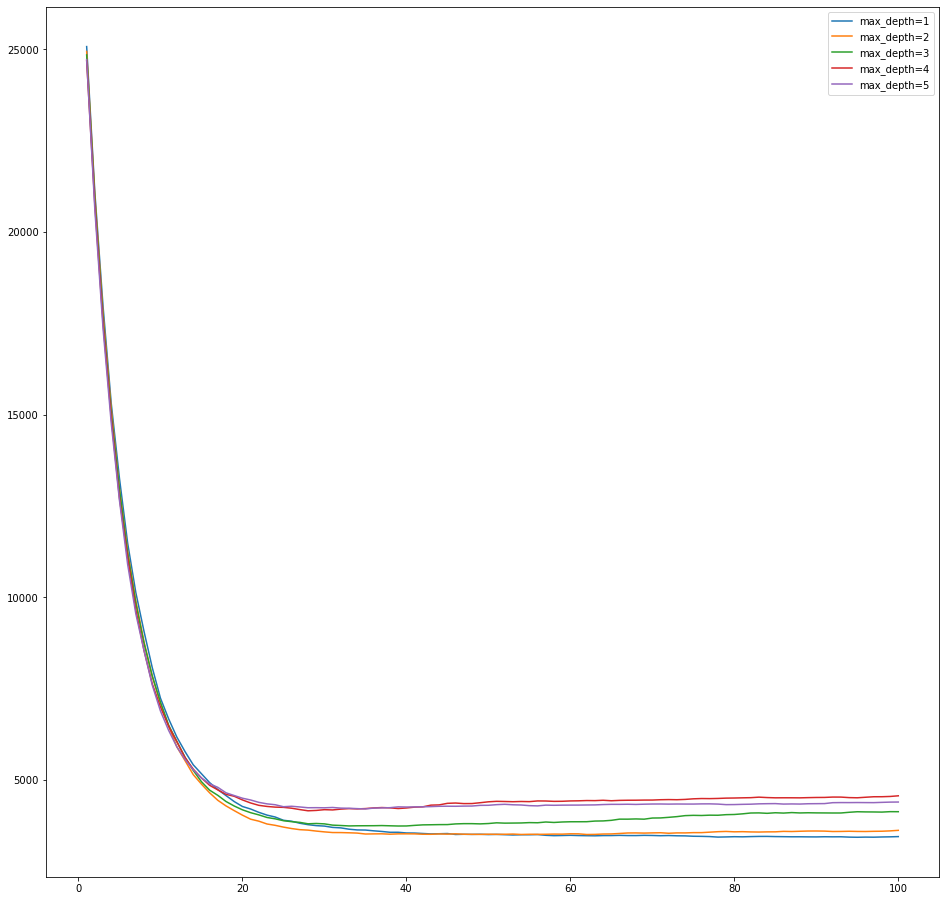

In [10]:
fig, ax = plt.subplots(figsize=(16,16))
for i, depth_errs in enumerate(errors, 1):
    ax.plot(np.arange(1, 101), depth_errs, label=f'max_depth={i}')
plt.legend()
plt.show()

In [ ]:
## лучше результаты показали модель 1 и 2 после 40 интерации
## С увеличением глубины и количества деревьев ошибка уменьшается, но при этом усиливается переобучение

In [ ]:
## Задание 2.
## Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг.
## Размер подвыборки принять равным 0.5.
## Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.


In [11]:
class GradientBoostingRegressor:
    def __init__(self, *args, n_iters=100, learning_rate=0.01, sample=1, **kwargs):
        self.args = args
        self.kwargs = kwargs
        self.n_iters = n_iters
        self.learning_rate = learning_rate
        self.sample = sample
        self.trees = None
        self.train_errors = None
        self.test_errors = None
        
    def fit(self, X_train, y_train, X_test=None, y_test=None):
        X_train = pd.DataFrame(X_train)
        y_train = pd.Series(y_train)
        self.trees = []
        self.train_errors = []
        self.test_errors = []
        for _ in range(self.n_iters):
            tree = DecisionTreeRegressor(*self.args, **self.kwargs)
            indexes = np.random.choice(X_train.index, int(X_train.shape[0] * self.sample), replace=False)
            if len(self.trees) == 0:
                tree.fit(X_train.loc[indexes], y_train.loc[indexes])
            else:
                y_pred = self.predict(X_train.loc[indexes])
                tree.fit(X_train.loc[indexes], self.bias(y_train.loc[indexes], y_pred))
            self.trees.append(tree)
            self.train_errors.append(mse(y_train, self.predict(X_train)))
            if (X_test is not None) and (y_test is not None):
                self.test_errors.append(mse(y_test, self.predict(X_test)))

    @staticmethod
    def bias(y_true, y_pred):
        return (y_true - y_pred)

    def predict(self, X):
        return np.sum([self.learning_rate * tree.predict(X) for tree in self.trees], axis=0)

In [12]:
gb_model = GradientBoostingRegressor(n_iters=200, learning_rate=0.1, sample=0.5, max_depth=4, random_state=42)
gb_model.fit(X_train, y_train, X_test, y_test)
y_pred = gb_model.predict(X_test)
mse(y_test, y_pred)

4149.234599995098

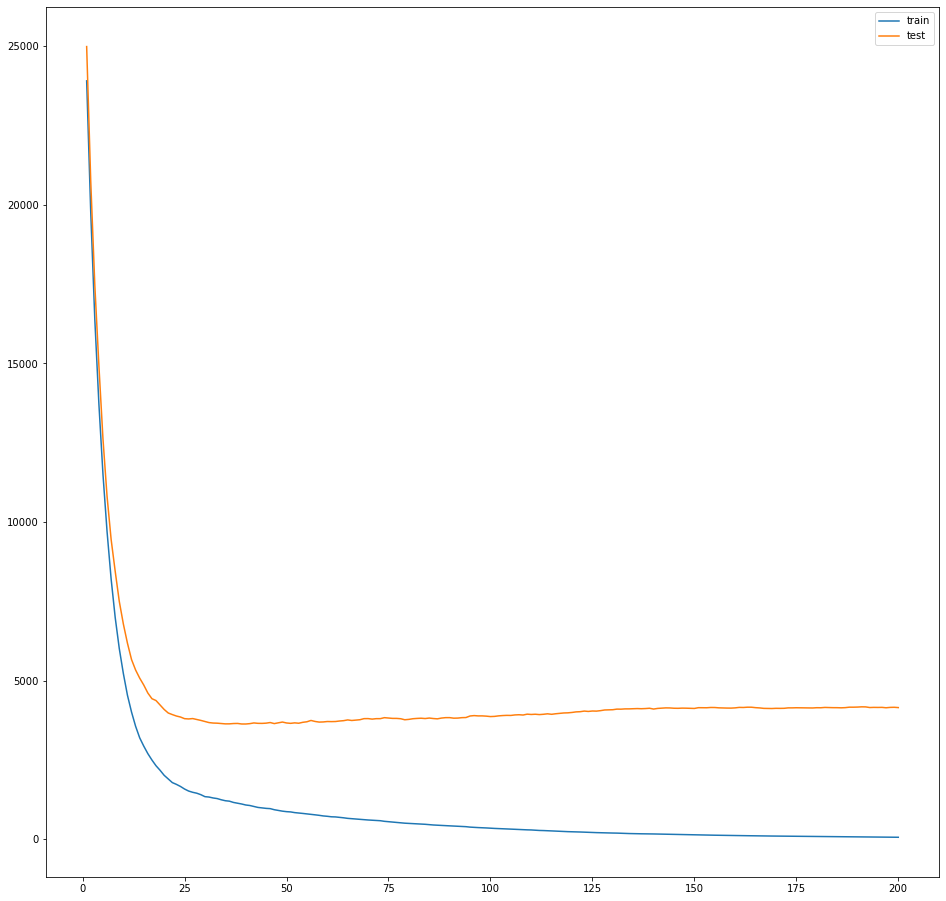

In [13]:
fig, ax = plt.subplots(figsize=(16,16))
train_errs = gb_model.train_errors
test_errs = gb_model.test_errors
ax.plot(np.arange(1, 201), train_errs, label='train')
ax.plot(np.arange(1, 201), test_errs, label='test')
plt.legend()
plt.show()

In [ ]:
## модель начинает переобучаться - ошибка на тесте растет приблизительно с 50 итерации.